# Titanic: Machine Learning from Disaster Model Development

This notebook aims at developing a machine learning model to predict the survival of passengers on the Titanic. Development process including data preparation strategies, model development, and evaluation of the models are presented in this notebook.

---

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib


In [4]:
# Charger les données
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

In [5]:
df = pd.read_csv(url)
data = df.copy()

---

## Data Preparation

In [9]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

trainset.shape, testset.shape

((712, 12), (179, 12))

In [10]:
trainset.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

## Feature Encoding

In [11]:
# Female and male encoding
trainset["Sex"] = trainset["Sex"].map({
    "female": 0,
    "male": 1
})

# Embarked encoding as one-hot encoding
trainset = pd.get_dummies(trainset, columns=["Embarked"], prefix="Embarked")

## Missing values imputation

In [12]:
# Drop missing age values
# trainset.dropna(subset=["Age"], inplace=True)

# Impute missing values for age
# trainset["Age"].fillna(trainset["Age"].mean(), inplace=True)  # Remplace NaN by the mean
trainset["Age"].fillna(trainset["Age"].median(), inplace=True)  # Remplace NaN by the median

**Explaintation**: 

First strategy was to drop the missing values in the age column. However, this strategy resulted in a significant loss of data and thus accuracy in the developed model. 

Therefore, the second strategy was to impute the missing values with the mean or median of the age column. The median imputation strategy was selected as it is less sensitive to outliers and turns out to give better accuracy.

## Data Train/Test Split

In [13]:
X, y = trainset.drop("Survived", axis=1), trainset["Survived"]
X.shape, y.shape

((712, 9), (712,))

## Model Development

To explore the different strategies for model development, we will use a Random Forest Classifier for its simplicity and efficiency in handling tabular data.

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)

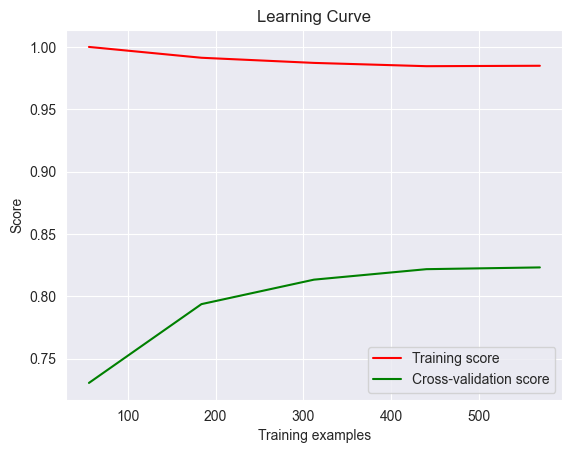

In [25]:
# plot curve
train_sizes, train_scores, test_scores = learning_curve(rf, X, y, cv=5, random_state=1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()


In [26]:
## Scale age and fare

scaler = StandardScaler()
X[["Age", "Fare"]] = scaler.fit_transform(X[["Age", "Fare"]])


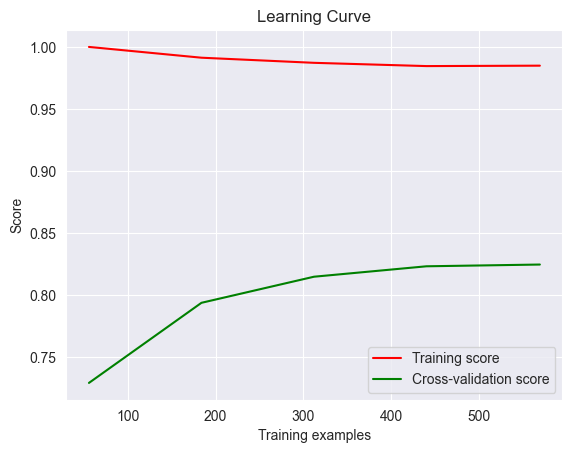

In [27]:
train_sizes, train_scores, test_scores = learning_curve(rf, X, y, cv=5, random_state=1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

Best strategy seems to normalize the data before training the model. We will now compare different models with different strategies to select the best model. 

I used a automated approach to compare different models with different strategies I already developed. 

---

In [15]:
def transform_all(X, normalize=True, columns_to_normalize=["Age", "Fare"]):
    """
    You can choose specific columns to normalize (e.g., 'Age', 'Fare')
    """

    if normalize:
        # Only normalize the selected columns
        scaler = StandardScaler()
        X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

    return X

def run_classifiers(X, y, clfs, verbose=False, scorer=None):
    """
    Retourne le meilleur modèle avec la meilleure stratégie

    Compare tous les modèles fournis avec les trois stratégies (default, normalize, normalize + pca)
    """

    stretegies = [
        "default", "normalize"
    ]

    best_model = None
    best_score = -np.inf
    best_strategy = None

    kf = KFold(n_splits=10, shuffle=True, random_state=0)

    for clf_name, clf in clfs.items():
        for strategy in stretegies:
            if verbose:
                print(f"\nTest du modèle : {clf_name} avec la stratégie : {strategy}")

            if strategy == "default":
                X = transform_all(X, normalize=False)
            elif strategy == "normalize":
                X = transform_all(X, normalize=True)

            cv_acc = cross_val_score(clf, X, y, cv=kf, scoring=scorer, n_jobs=-1)
            score = np.mean(cv_acc)

            if verbose:
                print(f"Score for {clf_name} is: {score:.3f} +/- {np.std(cv_acc):.3f}")

            if score > best_score:
                best_score = score
                best_model = clf
                best_strategy = strategy

    return best_model, best_strategy


In [16]:
clfs = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=1),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=1),
    "GradientBoosting": GradientBoostingClassifier(random_state=1)
}

In [17]:
best_model, best_strategy = run_classifiers(X, y, clfs, verbose=True, scorer="accuracy")


Test du modèle : RandomForest avec la stratégie : default
Score for RandomForest is: 0.827 +/- 0.063

Test du modèle : RandomForest avec la stratégie : normalize
Score for RandomForest is: 0.831 +/- 0.064

Test du modèle : MLP avec la stratégie : default
Score for MLP is: 0.816 +/- 0.052

Test du modèle : MLP avec la stratégie : normalize
Score for MLP is: 0.816 +/- 0.052

Test du modèle : GradientBoosting avec la stratégie : default
Score for GradientBoosting is: 0.830 +/- 0.051

Test du modèle : GradientBoosting avec la stratégie : normalize
Score for GradientBoosting is: 0.830 +/- 0.051


In [33]:
best_model, best_strategy

(RandomForestClassifier(random_state=1), 'default')

**Observations** : According to the results, the best model is the Random Forest Classifier with the normalization strategy. We will now perform a grid search to find the best hyperparameters for the model.

In [18]:
# Grid search

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 4, 6]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, None],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]})

In [19]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 100},
 np.float64(0.8483600906136116),
 RandomForestClassifier(max_depth=9, min_samples_split=4, random_state=1))

---

# Pipeline

This section aims at creating a pipeline to automate the data preprocessing and model training process. The pipeline will include the following steps:

- Drop unnecessary columns
- Preprocessing steps (imputation, scaling, encoding)
- Classifier

The pipeline will be trained on the entire dataset and saved for future use.

In [20]:
# Create a pipeline
X, y = df.drop(columns=['Survived']), df['Survived']

# Custom function to drop columns

def drop_columns(X):
    columns = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
    return X[columns]

# Create the FunctionTransformer
drop_columns_transformer = FunctionTransformer(drop_columns, validate=False)

# Define column categories for preprocessing
categorical_cols = ['Sex', 'Embarked']
numerical_cols = ['Age', 'Fare']
pass_through_cols = ['Pclass', 'SibSp', 'Parch']

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
        ('pass', 'passthrough', pass_through_cols)
    ],
    remainder='drop'
)

# Final pipeline with classifier
pipeline = Pipeline(steps=[
    ('drop_columns', drop_columns_transformer),  # Drop unnecessary columns first
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('classifier', grid_search.best_estimator_)  # Classifier
])

# Final pipeline with classifier
fixed_pipeline = Pipeline(steps=[
    # ('drop_columns', drop_columns_transformer),  # Drop unnecessary columns first
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('classifier', grid_search.best_estimator_)  # Classifier
])

pipeline.fit(X, y)
fixed_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass', 'SibSp',
                                                   'Parch'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_split=4,
                                        random_state=1))])

## Export the pipeline

In [48]:
# Extraire les composants du pipeline
trained_model = pipeline.named_steps['classifier']
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
scaler = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']

# Enregistrer les artefacts dans le dossier artifacts
joblib.dump(trained_model, '../artifacts/trained_model.pkl')
joblib.dump(encoder, '../artifacts/encoder.pkl')
joblib.dump(scaler, '../artifacts/scaler.pkl')
joblib.dump(drop_columns_transformer, '../artifacts/drop_columns_transformer.pkl')
joblib.dump(pipeline, '../artifacts/pipeline.pkl')
joblib.dump(fixed_pipeline, '../artifacts/fixed_pipeline.pkl')

print("Pipeline saved successfully!")

Artifacts enregistrés dans le dossier artifacts.
